## Contents:

1. Creates the final households initialized file by merging all the separately initialized files 
2. Creates census tract level initialized household files, which is going to used for parallelizing the main code
3. Integrated and Segregated network initializations for census tracts will be explored. How to measure these networks in terms of degree distributions and clustering coefficient will be determined. 
4. Policy interventions to be tested, will be outlined 

5. A final list of parameters for generating network scenarios will be listed

In [1]:
import pandas as pd 
import numpy as np 
import geopandas as gpd 
import os 
import random
import scipy.stats as stats     
import time
import networkx as nx 
import matplotlib.pyplot as plt 
%matplotlib inline 

path = os.getcwd()
#rootpath = 'c:\\Users\\Gamelab\\Desktop\\RT\\Others\\Thesis\\Thesis_coding\\ABM\\Solar-Adoption-Agent-based-Model\\'
rootpath = '/Users/rtseinstein/Documents/GitHub/Solar-Adoption-Model-ABM/'

rootpath

'/Users/rtseinstein/Documents/GitHub/Solar-Adoption-Model-ABM/'

# Testing for 1 agent: 49601

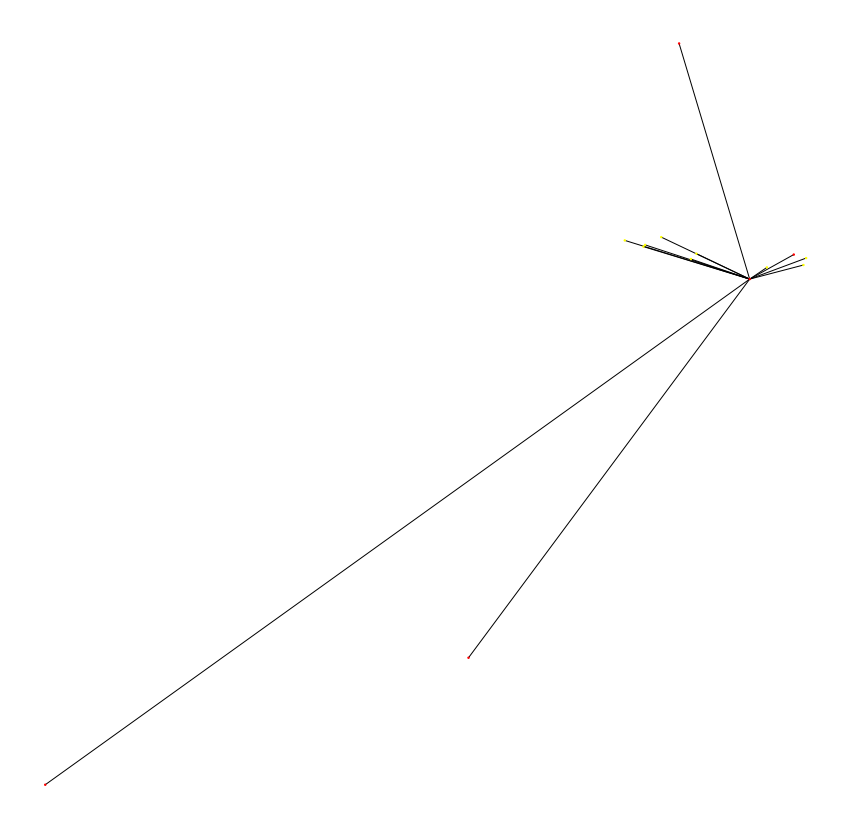

In [5]:
import random 
import contextily as cx
#declarations
block_dict = {}
incomegroup_dict = {}
blockgroup_incomegroup_dict= {}

#get the subset households file 
df = pd.read_csv(rootpath+'data\\households_subset\\subset_initialized_latlonvalues.csv')
# create an empty dictionary for storing agents block-wise 
for block in list(df['geoid'].unique()):
    block_dict[block] =[]

# create an empty dictionary for storing agents in same income-group 
                                                    ### CIRCLE OF INFLUENCE : CIRCLE-2 
for incomegroup in list(df['income'].unique()):
    incomegroup_dict[incomegroup]=[]

for blockgroup in list(df['bgid'].unique()):
    for incomegroup in list(df['income'].unique()):
        blockgroup_incomegroup_dict[(blockgroup,incomegroup)] = [] 

for _,row in df.iterrows():
    block_dict[row['geoid']].append(row['CASE_ID'])
    incomegroup_dict[row['income']].append(row['CASE_ID'])
    blockgroup_incomegroup_dict[(row['bgid'],row['income'])].append(row['CASE_ID'])

# i need to get every agent's network at the starting of the simulation

def circles_of_influence(agent,bgid,income):

    circle2 = blockgroup_incomegroup_dict[(bgid,income)]     # TODO: Remove the agent from their own circles of influence. 
    circle3 = incomegroup_dict[income]                         # returns a list of the members of the household's incomegroup bracket. 

    #print(circle2)
    #print(circle3)
    if circle2 is not None:
        circle2_choices = list(random.choices(circle2,k=min(len(circle2),3)))
        circle2 = [x for x in circle2 if x not in circle2_choices]
        
    else:
        circle2_choices=[] 

    if circle3 is not None:
        circle3_choices = list(random.choices(circle3,k=min(len(circle3),3)))
        circle3 = [x for x in circle3 if x not in circle3_choices]
        
    else:
        circle3_choices = [] 

    circle1= circle2_choices+circle3_choices  ## circle1 
    
    return circle1,circle2,circle3


agent = 49601
bgid = 136013
income = 'less75k'
a,b,c = circles_of_influence(agent,bgid,income)
#print(' circle1:',a,'\n circle2:',b,'\n circle3:',c)

G=nx.Graph()
lat = df.loc[df['CASE_ID']==agent,'lat'].values[0]
lon = df.loc[df['CASE_ID']==agent,'lon'].values[0]
G.add_node(agent,pos=(lat,lon),nodetype='red')
#circle1
for i in a:
    lat = df.loc[df['CASE_ID']==i,'lat'].values[0]
    lon = df.loc[df['CASE_ID']==i,'lon'].values[0]

    G.add_node(int(i),pos=(lat,lon),nodetype='red')
    G.add_edge(agent,i)

#circle2
b = [i for i in b if i!=agent]
for i in b:
    lat = df.loc[df['CASE_ID']==i,'lat'].values[0]
    lon = df.loc[df['CASE_ID']==i,'lon'].values[0]

    G.add_node(int(i),pos=(lat,lon),nodetype='blue')
    G.add_edge(agent,i)    

c = [i for i in c if i!=agent]
for i in b:
    lat = df.loc[df['CASE_ID']==i,'lat'].values[0]
    lon = df.loc[df['CASE_ID']==i,'lon'].values[0]

    G.add_node(int(i),pos=(lat,lon),nodetype='yellow')
    G.add_edge(agent,i)  

#for every agent in a, draw an edge between the agent and them 
colors = [u[1] for u in G.nodes(data="nodetype")]

fig,ax= plt.subplots(figsize=(15,15))

#albany = gpd.read_file(rootpath+'data\\shapefiles\\albany_census_blocks.shp')
#ax = albany.to_crs('EPSG:3857').plot(facecolor='blue',alpha=0.4,ax=ax)
#cx.add_basemap(ax)

nx.draw(G, nx.get_node_attributes(G,'pos'), node_color=colors, node_size=2,ax=ax)
#albany.to_crs('EPSG:3857').plot(facecolor='blue',alpha=0.4,ax=ax)


# Code for all agents

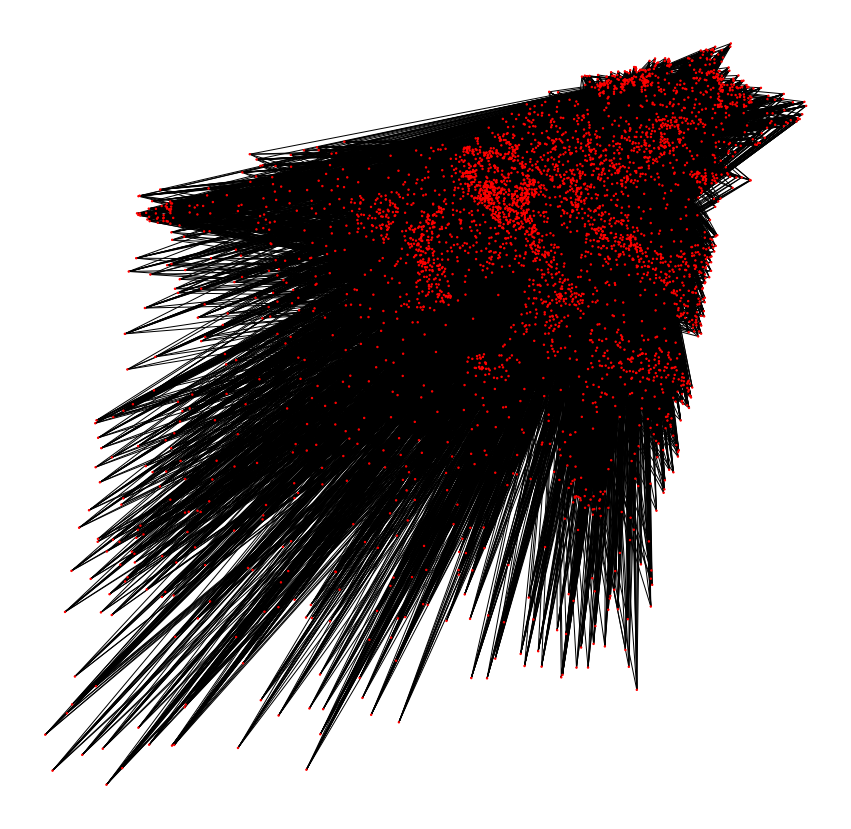

In [6]:
G=nx.Graph() # main graph 
for _,row in df.iterrows():
    agent = row['CASE_ID']
    bgid = row['bgid']
    income = row['income']
    lat = df.loc[df['CASE_ID']==agent,'lat'].values[0]
    lon = df.loc[df['CASE_ID']==agent,'lon'].values[0]
    G.add_node(agent,pos=(lat,lon),nodetype='red')  

    circle1,circle2,circle3 = circles_of_influence(agent,bgid,income)

    for i in a:
        lat = df.loc[df['CASE_ID']==i,'lat'].values[0]
        lon = df.loc[df['CASE_ID']==i,'lon'].values[0]

        G.add_node(int(i),pos=(lat,lon),nodetype='red')
        G.add_edge(agent,i)

    #circle2
    b = [i for i in b if i!=agent] 
    for i in b:
        lat = df.loc[df['CASE_ID']==i,'lat'].values[0]
        lon = df.loc[df['CASE_ID']==i,'lon'].values[0]

        G.add_node(int(i),pos=(lat,lon),nodetype='blue')
        G.add_edge(agent,i)    

    c = [i for i in c if i!=agent]
    for i in b:
        lat = df.loc[df['CASE_ID']==i,'lat'].values[0]
        lon = df.loc[df['CASE_ID']==i,'lon'].values[0]

        G.add_node(int(i),pos=(lat,lon),nodetype='yellow')
        G.add_edge(agent,i)  

    #for every agent in a, draw an edge between the agent and them 
colors = [u[1] for u in G.nodes(data="nodetype")]

fig,ax= plt.subplots(figsize=(15,15))
nx.draw(G, nx.get_node_attributes(G,'pos'), node_color=colors, node_size=2,ax=ax)



# To Reduce Computational Complexity

Because the model can run smoothly at a rate of 1000-2000 agents for the whole 36 runs, I can aim to split my running across zip-codes and implement that in batches. 
For that, I have to get an estimate of how many households I have, per zip-code. The following steps are taken to get households by the zip-code or blockgroup (both attempts)

## Block-group 
1. Get the counts of households per bgid

In [3]:
df = pd.read_csv(rootpath+'data/households_main/households_main.csv')
df = df.drop(columns=['Unnamed: 0','rand_point'])
df.head(3)

#80,301 households
#bgid and tractce10 are the same 

case_id    bgid     age     income     sample_inc  ami_catego  tract  \
0    33813  146151  65plus   75to100k   89442.088666           3  14615   
1    33830  146151  25to44  100to150k  140645.319203           3  14615   
2    33837  146151  25to44  100to150k  105041.215221           3  14615   

   elec_consu  TRACTCE10  BLOCKCE10       GEOID10  \
0  105.215875    14615.0     1009.0  3.600101e+14   
1  105.215875    14615.0     1009.0  3.600101e+14   
2  105.215875    14615.0     1009.0  3.600101e+14   

                                       geometry  household_  
0  POINT (-73.90985282571991 42.70169232207814)           0  
1   POINT (-73.91041445667243 42.6990450141003)           0  
2   POINT (-73.9113375483074 42.70291955532851)           0

<AxesSubplot:ylabel='Frequency'>

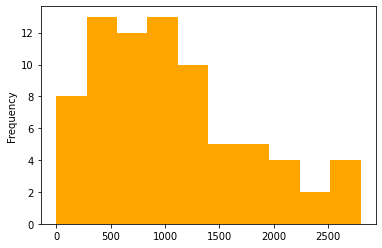

In [8]:
#bgid = blockgroupid 
df.groupby('TRACTCE10')['case_id'].count().sort_values().plot.hist(color='orange')

In [9]:
## number of census tracts: 
len(df.TRACTCE10.unique())

77

### The idea: 

As is evident from the plot above, the numbers are far more manageable from a computational perspective, for 36 timesteps. The process envisioned is as follows:
- 1. Geographic links are within blocks (geoid) 
- 2. Core group: 
- 3. second circle of workplace friends: within the same blockgroup (bgid) 
- 4. Third circle (can have 200 people from anywhere in albany, but interact with only 0.01 percent of them in a timestep). The ideal number of interactions will be about 5+15+20  = 40 people every month. 

So, 1000*40 = 40,000 interactions in total, for 36 timesteps.

Number of census tracts: 77 


- Go through tract-wise and save the households belonging to 1 tract in a separate file.
- read in two files at start of simulation: 
    --  the tract file, 
    --  the file with all of the households
- GEO LINK: (neighbhourhood level) For every household in the tract, groupby geoid (block), add them to the geo circle and every timestep sample from 3 or 4 max and draw Geographic links between them and add these pairs to interaction list. 
- CIRCLE TWO: For every household, all the agents within the (bgid and same income-group) are potential friends. Add a sample of them (about 50) into the network. Every timestep, sample 15 from them. 
- CIRCLE THREE: For every household, in the third circle, anyone within albany (in same income group) is within reach. Add a sample of them (about 150) into network. Every timestep, sample about 20 from them. 
- CIRCLE ONE CORE: a fixed number of 5 people that the household interacts with on a daily basis. no sampling. a fixed number of 6 people (3 from circle 2 and 3 from circle 3- after this sampling, they are removed from these circles) 


# Creating tract-level household data files



In [12]:
import glob

attitude_dict = {}
pbc_dict={}
subnorms_dict= {}

def map_tpb(file):
    df = pd.read_csv(file)
    df = df.drop(columns='Unnamed: 0')

    df = df.set_index('CASE_ID')
    attitude_dict.update(df['attitude'].to_dict())
    pbc_dict.update(df['pbc'].to_dict())
    subnorms_dict.update(df['subnorms'].to_dict())

filenames = glob.glob(rootpath+'data/initialization_subsets_24/*.csv')

for file in filenames:
    map_tpb(file)

df['attitude'] = df['case_id'].map(attitude_dict)
df['pbc'] = df['case_id'].map(pbc_dict)
df['subnorms'] = df['case_id'].map(subnorms_dict)

df= df.dropna(subset=['attitude'])
#df.to_csv(rootpath+'data/households_main/households_main_initialized.csv')


# Now, creating the separate tract-level files
tracts = list(df.TRACTCE10.unique()) 
counter = 0
for tract in tracts:
    
    counter+=1
    df_tract = df.loc[df['TRACTCE10']==tract]
    #df_tract.to_csv(rootpath+f'data/households_censustracts/tract_{str(int(tract))}.csv')
    print(f'created file for tract {int(tract)}')

print(f'{counter} files created for all tracts')



# Integrated Networks

1. Read a tract level file. 
2. For every household in the file, create four circles:


    -- geolink : the agent will have in its network possibility of interacting with anyone in the geoid. 


    -- circle2 : 
    --- network: sample upto 50 people in the same bgid of any income group. 
    --- interaction: at every timestep, sample upto 15 for interaction 


    -- circle3 :
    --- network: sample upto 150 people within albany of any income group. 
    --- interaction: at every timestep, sample upto 20 for interaction. 
    

    -- circle1 :
    --- network: sample 3 from circle2 + 2 from circle3
    --- interaction: at every timestep interact with all 5 of them
    --- remove these agents from circle2 and circle3 




In [24]:
households_main.columns

Index(['case_id', 'bgid', 'age', 'income', 'sample_inc', 'ami_catego', 'tract',
       'elec_consu', 'TRACTCE10', 'BLOCKCE10', 'GEOID10', 'geometry',
       'household_', 'attitude', 'pbc', 'subnorms'],
      dtype='object')

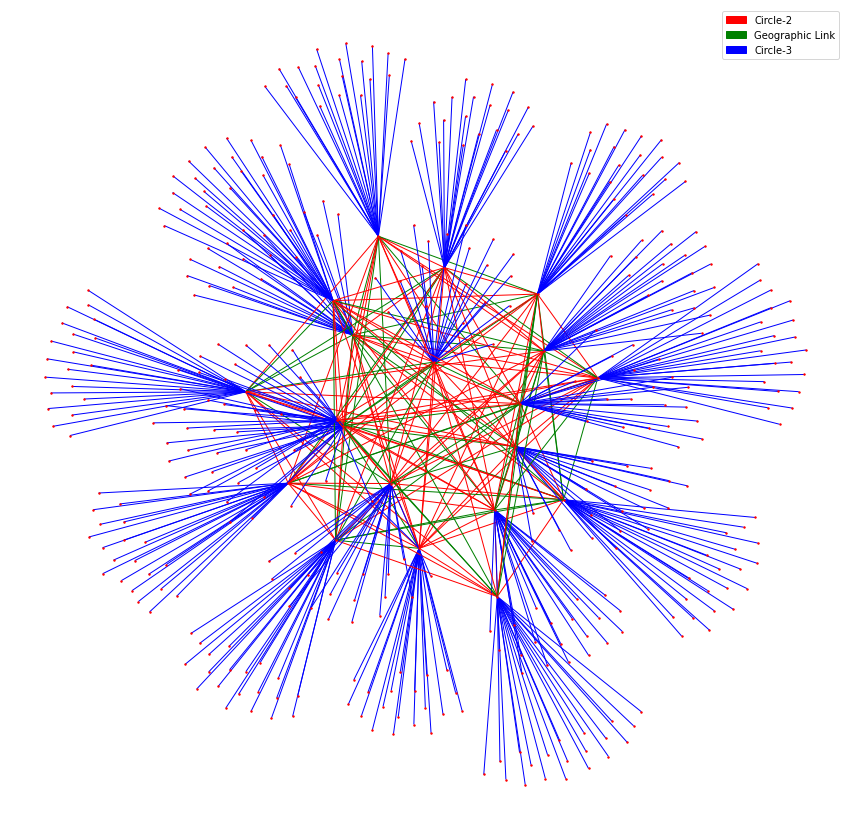

In [46]:
import matplotlib.patches as mpatches

households_main = pd.read_csv(rootpath+'data/households_main/households_main_initialized.csv')
households_main = households_main.drop(columns='Unnamed: 0')

tracts = list(households_main['TRACTCE10'].unique())
tracts = [int(i) for i in tracts]

sample = random.choice(tracts)
sample = pd.read_csv(rootpath+f'data/households_censustracts/tract_{sample}.csv')
sample = sample.head(20)
bgid_members = {}
for i in list(sample['bgid'].unique()):
    bgid_members[i] = list(sample.loc[sample['bgid']==i,'case_id'].values)

geoid_members = {}
for i in list(sample['GEOID10'].unique()):
    geoid_members[i] = list(sample.loc[sample['GEOID10']==i,'case_id'].values)

all_households = list(households_main['case_id'].unique())

geolinks = {}
circle1 = {}
circle2 = {}
circle3 = {}

G= nx.Graph()

for _,row in sample.iterrows():
    G.add_node(row['case_id'])
    #circle2
    #get the neighbhours list of the agent's bigd. 
    bgid_neighs = bgid_members[row['bgid']]
    for i in bgid_neighs:
        G.add_node(i)
    #draw edges between agent to upto 15 area friends
    bgid_neighs = random.choices(bgid_neighs, k=min(len(bgid_neighs),15))
    bgid_neighs = [i for i in bgid_neighs if i!=row['case_id']]
    for i in bgid_neighs:
        G.add_edge(row['case_id'],i,color='r',label='circle-2')
    circle2[row['case_id']]= bgid_neighs

    #geolinks
    #get geoid
    neighs = geoid_members[row['GEOID10']]
    for i in neighs:
        G.add_node(i)
    #draw edges between agent to upto 5 neighbhours
    neighs = random.choices(neighs, k=min(len(neighs),5))
    neighs = [i for i in neighs if i!=row['case_id']]
    for i in neighs:
        G.add_edge(row['case_id'],i,color='g',label='geo-link')

    geolinks[row['case_id']]=neighs

    #circle3
    thirdcircle = random.choices(all_households,k=20)
    thirdcircle = [i for i in thirdcircle if i!= row['case_id']]
    for i in thirdcircle:
        G.add_node(i)
        G.add_edge(row['case_id'],i,color='b',label='circle-3')

    circle3[row['case_id']]= thirdcircle

colors = nx.get_edge_attributes(G,'color').values()

r = mpatches.Patch(color='red', label='Circle-2')
g = mpatches.Patch(color='g', label='Geographic Link')
b= mpatches.Patch(color='b', label='Circle-3')


fig,ax = plt.subplots(figsize=(15,15))
pos = nx.spring_layout
nx.draw(G, edge_color=colors, node_color='red', node_size=2, ax=ax)
plt.legend(handles=[r,g,b])




